# Backtesting notebook

This notebook will serve as an environment to quickly test quantitative strategies.

Code that needs to be changed by the user is marked with ##########

In [1]:
from matplotlib import pyplot as plt
import openpyxl
import numpy as np
import pandas as pd
import talib as ta
import yfinance as yf
import time
import itertools

import backtest_module as bm

In [10]:
start_date, end_date = "2016-01-01", "2022-01-01"
ticker = "INVE-B.ST"
interval = '1d'
df = yf.download(tickers=ticker, start=start_date, end=end_date, multi_level_index=False, interval=interval)
df = df[['Close']]
df

C:\Users\jens2\AppData\Local\Temp\ipykernel_34772\1925373768.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers=ticker, start=start_date, end=end_date, multi_level_index=False, interval=interval)
[*********************100%***********************]  1 of 1 completed


,Close
Date,
2016-01-04,59.566116
2016-01-05,59.149429
2016-01-07,57.839836
2016-01-08,57.700951
2016-01-11,57.720791
...,...
2021-12-23,205.679031
2021-12-27,209.537857
2021-12-28,211.583466


# Define a strategy

Takes in data, could be any sort of time-series data. Returns np.ndarray of shape (N, A) where A is the number of assets the strategy is trading. N is the number of rows of the given data. Every column in the returned array consists of (1, 0, -1) and represents a (Long, Neutral, Short) order. The order of columns determining which signal goes to what asset needs to match the order of columns given to the class Backtest columns_assets.

In [11]:
def general_signal_function(data, *parameters):
    number_of_assets = 4
    signal_matrix = np.zeros(shape=(data.shape[0], number_of_assets))
    
    ##########
    # Strategy here
    ##########

    if signal_matrix.shape!=data.shape:
            AssertionError(f"Expected shape: {data}, but got {signal_matrix.shape}.")
    return signal_matrix
    


### Example of strategy

In [12]:
def moving_average_signal(data, *parameters):
    '''
    How the signal should be created:
    Input: Only parameters nothing else.
    Output: A np.ndarray of shape = (N, A) <--- VERY IMPORTANT!!!
        N: The number of bars in our original df.
        A: The number of tradable assets.
    Values must strictly be: (1, 0, -1) corresponding to (Long position, no position, Short position).
    '''
    ######## ENTER STRATEGY HERE ########
    close = data[:,0]
    ma_short = ta.SMA(close, timeperiod=parameters[0])
    ma_long = ta.SMA(close, timeperiod=parameters[1])

    signal = np.where(
        (ma_short > ma_long) &
        (close > ma_short) &
        (close > ma_long),
        1, 0
        )
    signal = np.where(
        (ma_short < ma_long),
        0, signal
        )
    
    signal_matrix = np.array([signal]).T
    
    return signal_matrix

### The Backtest class

We begin by creating an instance of the class Backtest.

#### Inputs
- df: pandas.Dataframe containing data from the assets the strategy will trade, and data the strategy needs to determine a signal (Observe that one column can be included in both sets).
- columns_assets: List of columns that are assets the strategy will trade.
- columns_signal: List of columns that are needed to determine a signal.
- signal_function: The function that creates our signal.
- ohlc_columns: Jagged array. Each inner list contains column names in the order Open, High, Low, Close for a given asset. The reason for this is in order for our Monte-Carlo permutation test to permutate data in a reasonably way.
- non_financial_columns: List of columns that contains non financial data. The data of the given columns will be permutated by permutating entire values, as supposed to permutating returns.
- comission: Comission expressed as precentage or fixed sum depending on bool value of precentage_comission.

In [13]:
##########
# Creating instance of Backtest class.
backtest = bm.Backtest(df=df,
                       columns_assets=['Close'],
                       columns_signal=['Close'],
                       signal_function=moving_average_signal,
                       #ohlc_columns=[[]],
                       #non_financial_columns=[],
                       comission=0.0,
                       precentage_comission=True
                        )

# Creating parameters ranges we want to study.
param_vector_1 = np.arange(20, 70, 4)
param_vector_2 = np.arange(120, 240, 4)

param_vectors = [param_vector_1, param_vector_2]
##########

# Deciding metric we want to optimize with regards to.
metric = "profit-factor"

# Computing buy and hold profit factor.
buy_n_hold_profit_factor = backtest.get_metric(df.to_numpy(), metric)

# Computing optimal portfolio.
optimal_params, optimal_profit_factor, optimal_equity_array = backtest.find_best_param(*param_vectors, metric=metric)

# Writing results in .xlsx document.
df = pd.read_excel('backtest_results.xlsx', sheet_name="general-metrics", index_col=0)
df[f"{ticker}-{start_date}-{end_date}"] = [optimal_profit_factor, buy_n_hold_profit_factor]
with pd.ExcelWriter("backtest_results.xlsx", engine="openpyxl", mode='a', if_sheet_exists='replace') as writer:
    df.to_excel(writer, sheet_name="general-metrics")

In [14]:
# Number of permutations to run in Monte Carlo permutation test.
# OBS! Can take long time! Be aware of number of parameters combinations and number of Monte Carlo runs.
N = 1000

start_time = time.perf_counter()
best_params_array, best_metric_array, best_equity_matrix_array = backtest.run_perm_test(*param_vectors, N=N)
end_time = time.perf_counter()
print(f"Time it took for N = {N}: {end_time - start_time}")

Time it took for N = 1000: 45.572120899974834


## Monte-Carlo permutation test
Below we can get a quick intuition for how likely it is that our strategy actually has an edge.

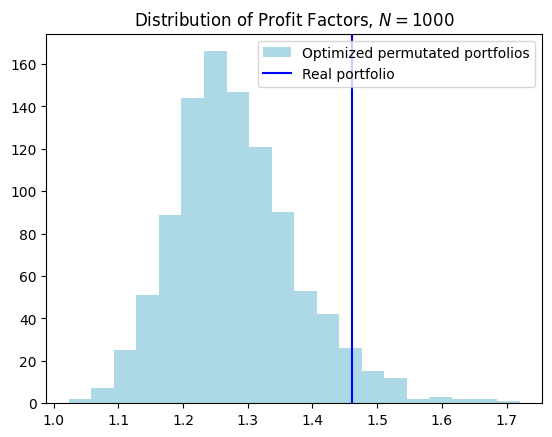

p-level after permutation test: 4.9%


In [15]:
backtest.plot_permutation_result(optimal_profit_factor=optimal_profit_factor, bins=20)

## Walk forward optimization
### Partition of Walk-Forward tests

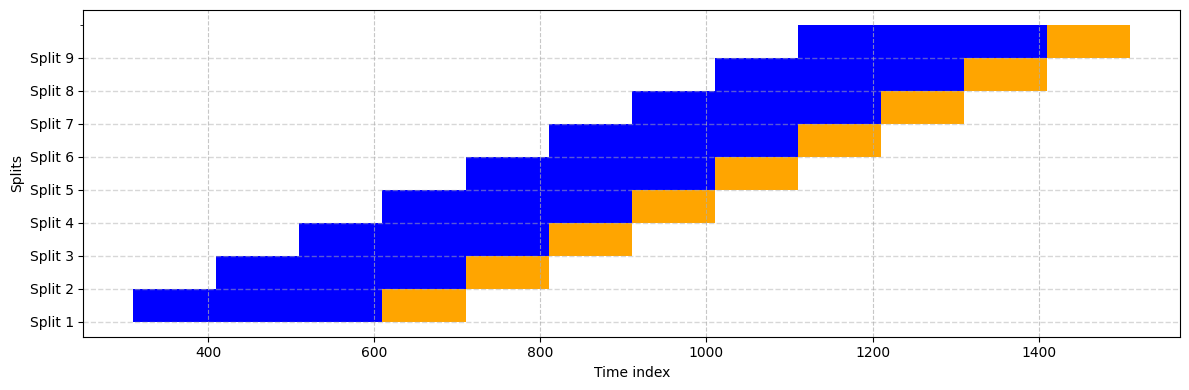

In [16]:
backtest.partition_walk_forward_data(n_splits=9,
                                     train_size=300,
                                     test_size=100,
                                     plot=True)

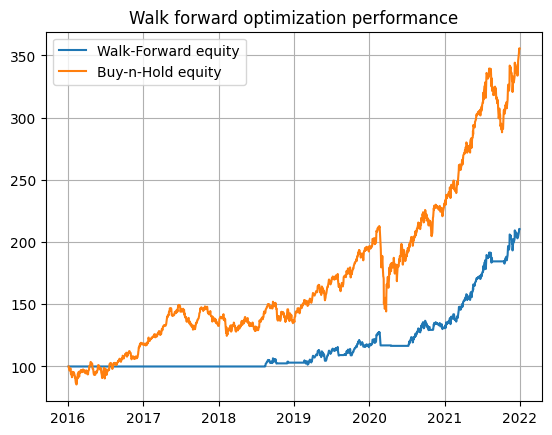

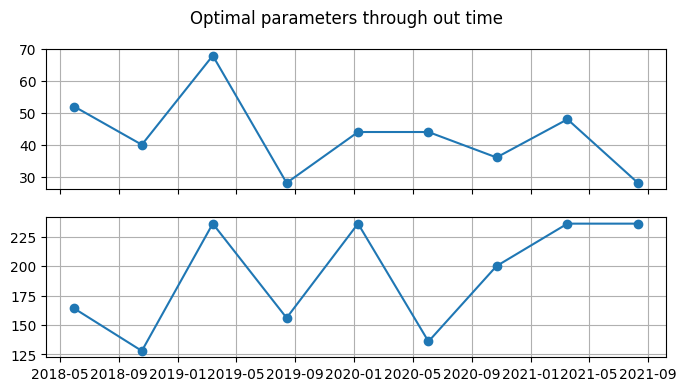

In [17]:
wf_backtest = backtest.run_walk_forward(*param_vectors, metric="profit-factor")
backtest.plot_walk_forward()